# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:03<00:00, 2610.62it/s]


In [23]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [24]:
#Helper function to print heatmap from confusionmatrix. Used Later 
#Source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

/home/rishiraj/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/rishiraj/.local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9327181853133412
The AUC Score of test data using BoW and L1 regularizer=  0.7215166110640306


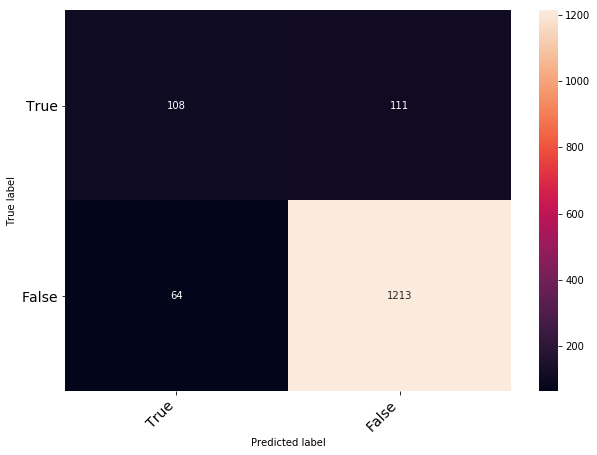

In [18]:
# Please write all the code with proper documentation

# Split data into train/test first.
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# Convert text data into BOW
#BoW on Train Data
count_vect = CountVectorizer() #in scikit-learn
final_counts_train = count_vect.fit_transform(X_train)
#BoW On Test Data
final_counts_test = count_vect.transform(X_test)

# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model1 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=5)
model1.fit(final_counts_train, y_train)
print(model1.best_estimator_)
y_pred = model1.predict(final_counts_test);
print(model1.score(final_counts_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using BoW and L1 regularizer= ",roc_auc)

# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [19]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(final_counts_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

print("Sparsity Density on weight vector using L1 regularizer is = ",(np.count_nonzero(w)/len(clf.coef_[0]))*100,"%")
#print(clf.coef_) # returns a matrix of weights (coefficients)

606
Sparsity Density on weight vector using L1 regularizer is =  5.521137026239066 %


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.937308868501529
The AUC Score of test data using BoW and L2 regularizer=  0.7220404558343434


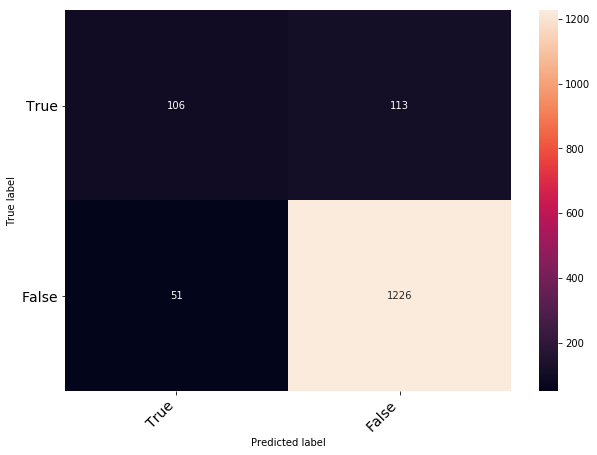

In [20]:
# Split data into train/test first.
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# Convert text data into BOW
#BoW on Train Data
count_vect = CountVectorizer() #in scikit-learn
final_counts_train = count_vect.fit_transform(X_train)
#BoW On Test Data
final_counts_test = count_vect.transform(X_test)

# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model2 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=5)
model2.fit(final_counts_train, y_train)
print(model2.best_estimator_)
y_pred = model2.predict(final_counts_test);
print(model2.score(final_counts_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using BoW and L2 regularizer= ",roc_auc)

# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

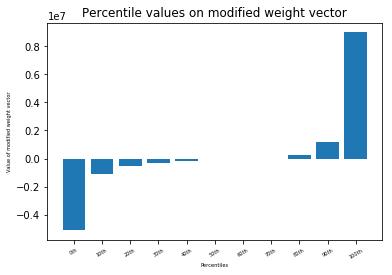

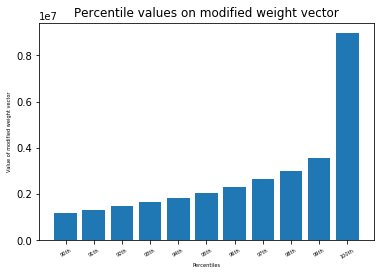

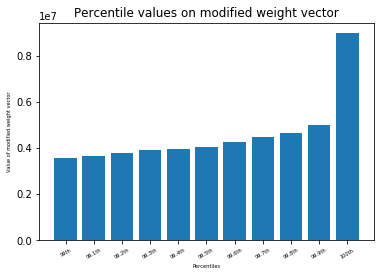

{Feature Name: Corresponding Weight} whose value is greater then threshold

{'bully': 5201022.433166781, 'gerber': 5587628.547602498, 'lacked': 5646750.481758557, 'marginally': 5057396.8742815275, 'miss': 8972952.09729046, 'mug': 5363733.645623017, 'potatoe': 6746289.0617394615, 'tasteless': 5320494.316464755, 'threw': 5046933.643537933, 'verytasty': 5171593.731458778, 'wafer': 5597781.881201232}


In [21]:
# Please write all the code with proper documentation

#Get the weights W after fit your model with the data X.
w = clf.coef_
#Take precaution to avoid division by zero error
w = [x+10e-6 for x in w[0]]
#Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
noise = np.random.normal(0,1,1)
final_counts_train.data+=int(noise)
#Fit the model again on data X' and get the weights w_new
clf = LogisticRegression(C=1, penalty='l2');
clf.fit(final_counts_train, y_train);
w_new = clf.coef_
#Take precaution to avoid division by zero error
w_new = [x+10e-6 for x in w_new[0]]

#Now find the % change between W and W' (| (W-W') / (W) |)*100)
w_intr = [x1 - x2 for (x1, x2) in zip(w, w_new)]
w_final = [(x1/x2)*100 for (x1, x2) in zip(w_intr, w)]

w_final = np.array(w_final)
pcentile_w = []
for i in range(0,110,10):
    pcentile_w.append(round(np.percentile(w_final, i),2))

import matplotlib.pyplot as plt
def plot_bar_x(label, y):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, y)
    plt.xlabel('Percentiles', fontsize=5)
    plt.ylabel('Value of modified weight vector', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Percentile values on modified weight vector')
    plt.show()

label = ['0th','10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', '100th']
plot_bar_x(label,pcentile_w)
pcentile_w = []
for i in range(90,101,1):
    pcentile_w.append(round(np.percentile(w_final, i),2))

label = ['90th','91th','92th', '93th', '94th', '95th', '96th', '97th', '98th', '99th', '100th']
plot_bar_x(label,pcentile_w)

pcentile_w = []
for i in np.linspace(99, 100, num=11):
    pcentile_w.append(round(np.percentile(w_final, i),2))
    
label = ['99th','99.1th','99.2th', '99.3th', '99.4th', '99.5th', '99.6th', '99.7th', '99.8th', '99.9th', '100th']
plot_bar_x(label,pcentile_w)

#code to find the value after which there is an abrupt rise in percentile value

#Print the feature names whose % change is more than a threshold x
final_features_weight = {}
feature_index = 0
for i in w_final:
    if i>np.percentile(w_final, 99.9):
        final_features_weight[count_vect.get_feature_names()[feature_index]] = i
    feature_index+=1
print("{Feature Name: Corresponding Weight} whose value is greater then threshold\n")
print(final_features_weight)

Observation: The most change in percetile occurs between 90th and 100th percetile. Therefore we observe the 90th to 100th percentile in more detail

Observation: The most change in percetile occurs between 99th and 100th percetile. Therefore we observe the 90th to 100th percentile in more detail

Observation: The value after which there is a abrupt rise in percentile value is the value corresponding to 99.9 percentile.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [22]:
#feature importance on BoW with L2 regularizer

import operator
importantFeaturesBOW = {}
index = 0
for i in count_vect.get_feature_names():
    importantFeaturesBOW[i] = w[index]
    index+=1
    
#Sorting the features with from higher weight to lower weight
sortedImportantFeaturesBOW = sorted(importantFeaturesBOW.items(), key=operator.itemgetter(1), reverse=True)
print("Top 10 features of BoW are\n")
print(sortedImportantFeaturesBOW[0:10])


Top 10 features of BoW are

[('delicious', 2.7547956069836332), ('run', 2.1107463332268526), ('nice', 2.037879054960364), ('amazing', 1.9924842292213598), ('heavy', 1.90717444154939), ('highly', 1.8759887724632724), ('perfect', 1.758214951288716), ('excellent', 1.6990869876088004), ('stores', 1.6779024643939622), ('stars', 1.5818905793492593)]


#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [23]:
# Please write all the code with proper documentation
sortedImportantFeaturesBOW[0:10]

[('delicious', 2.7547956069836332),
 ('run', 2.1107463332268526),
 ('nice', 2.037879054960364),
 ('amazing', 1.9924842292213598),
 ('heavy', 1.90717444154939),
 ('highly', 1.8759887724632724),
 ('perfect', 1.758214951288716),
 ('excellent', 1.6990869876088004),
 ('stores', 1.6779024643939622),
 ('stars', 1.5818905793492593)]

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation
sortedImportantFeaturesBOW[-10:len(sortedImportantFeaturesBOW)]

[('mushy', -2.022762304892682),
 ('date', -2.0384667074719887),
 ('google', -2.0394900033376993),
 ('disappointed', -2.2579013891166646),
 ('awful', -2.294466846646558),
 ('typically', -2.7192485536022275),
 ('yuck', -2.8012063932681093),
 ('swiss', -2.850680995873835),
 ('disappointing', -2.9326941986972246),
 ('hopes', -3.186353783314823)]

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9374534623976174
The AUC Score of test data using TFIDF and L1 regularizer=  0.650486478368608


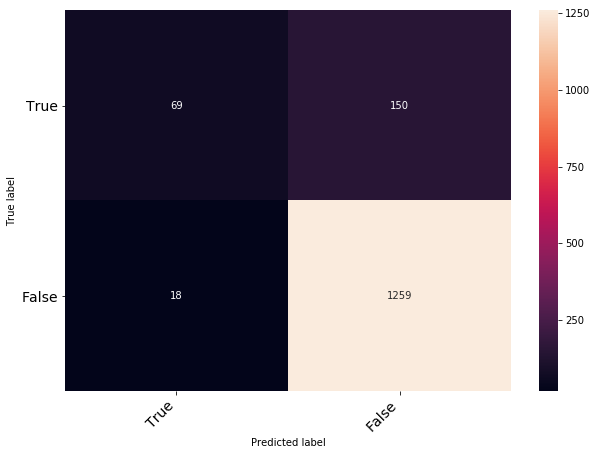

In [25]:
# Please write all the code with proper documentation

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# Convert text data into BOW
#BoW on Train Data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect_train = tf_idf_vect.fit_transform(X_train)
#BoW On Test Data
tf_idf_vect_test = tf_idf_vect.transform(X_test)

# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model2 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=5)
model2.fit(tf_idf_vect_train, y_train)
print(model2.best_estimator_)
y_pred = model2.predict(tf_idf_vect_test);
print(model2.score(tf_idf_vect_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using TFIDF and L1 regularizer= ",roc_auc)


# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9430011632415666
The AUC Score of test data using TFIDF and L2 regularizer=  0.7797688646692627


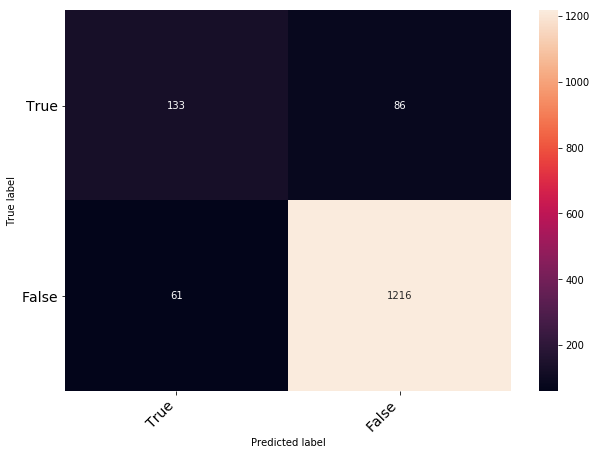

In [26]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# Convert text data into BOW
#BoW on Train Data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect_train = tf_idf_vect.fit_transform(X_train)
#BoW On Test Data
tf_idf_vect_test = tf_idf_vect.transform(X_test)

# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model2 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=5)
model2.fit(tf_idf_vect_train, y_train)
print(model2.best_estimator_)
y_pred = model2.predict(tf_idf_vect_test);
print(model2.score(tf_idf_vect_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using TFIDF and L2 regularizer= ",roc_auc)

# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [27]:
# Please write all the code with proper documentation
import operator

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(tf_idf_vect_train, y_train);
w = clf.coef_
w = [x+10e-6 for x in w[0]]

importantFeaturesTFIDF = {}
index = 0
for i in tf_idf_vect.get_feature_names():
    importantFeaturesTFIDF[i] = w[index]
    index+=1
    
#Sorting the features with from higher weight to lower weight
sortedImportantFeaturesTFIDF = sorted(importantFeaturesTFIDF.items(), key=operator.itemgetter(1), reverse=True)
print("Top 10 features of BoW are\n")
print(sortedImportantFeaturesTFIDF[0:10])

Top 10 features of BoW are

[('great', 10.430433811946868), ('delicious', 8.783667375969305), ('love', 8.029208705773438), ('good', 6.918149784181861), ('nice', 5.995998828425193), ('best', 5.499938382305305), ('perfect', 4.702172877114363), ('excellent', 4.505265259790524), ('always', 3.8195714016125715), ('loves', 3.7387772299293283)]


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [28]:
# Please write all the code with proper documentation
print(sortedImportantFeaturesTFIDF[-10:len(sortedImportantFeaturesTFIDF)])

[('worst', -3.992271367827198), ('ingredient', -4.176660489497302), ('return', -4.2787164566646805), ('swiss miss', -5.327876515829303), ('away', -5.517379188157397), ('not good', -5.666977697354542), ('disappointing', -6.318817586044053), ('awful', -6.348672973312195), ('not', -6.838155988876208), ('disappointed', -8.457220127511464)]


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

100%|██████████| 1496/1496 [00:01<00:00, 1096.58it/s]


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9218691588785046
The AUC Score of test data using AVG-W2V and L1 regularizer=  0.6060597933941922


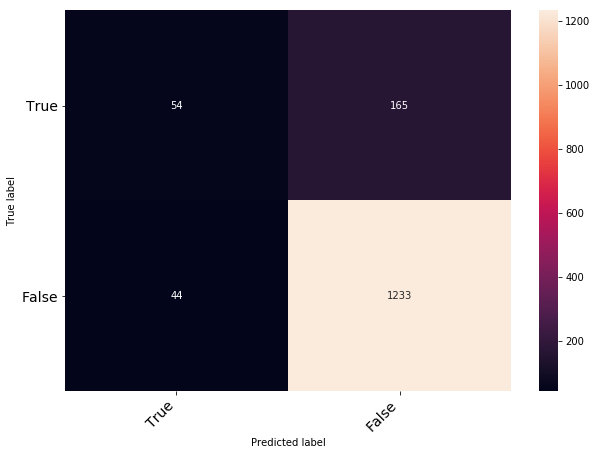

In [29]:
# Please write all the code with proper documentation
# average Word2Vec
i=0
list_of_sentance=[]
list_of_sentance_train=[]
list_of_sentance_test=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


#train test Split of data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)


for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    
sent_vectors_train = []; # the avg-w2v for each sentence/review in train set is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
    
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review in test set is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model3 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=5)
model3.fit(sent_vectors_train, y_train)
print(model3.best_estimator_)
y_pred = model3.predict(sent_vectors_test);
print(model3.score(sent_vectors_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using AVG-W2V and L1 regularizer= ",roc_auc)

# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

100%|██████████| 1496/1496 [00:01<00:00, 1256.07it/s]


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9222139117427076
The AUC Score of test data using AVGW2v and L2 regularizer=  0.6083428984170234


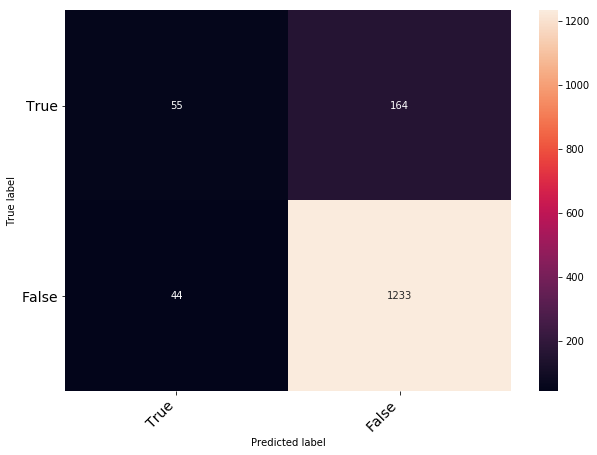

In [30]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
list_of_sentance_train=[]
list_of_sentance_test=[]

for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    
sent_vectors_train = []; # the avg-w2v for each sentence/review in train set is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
    
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review in test set is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model3 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=5)
model3.fit(sent_vectors_train, y_train)
print(model3.best_estimator_)
y_pred = model3.predict(sent_vectors_test);
print(model3.score(sent_vectors_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using AVGW2v and L2 regularizer= ",roc_auc)

# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 1496/1496 [00:03<00:00, 376.20it/s]


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9166666666666665
The AUC Score of test data using TFIDF weighted W2V and L1 regularizer=  0.5737047803964057


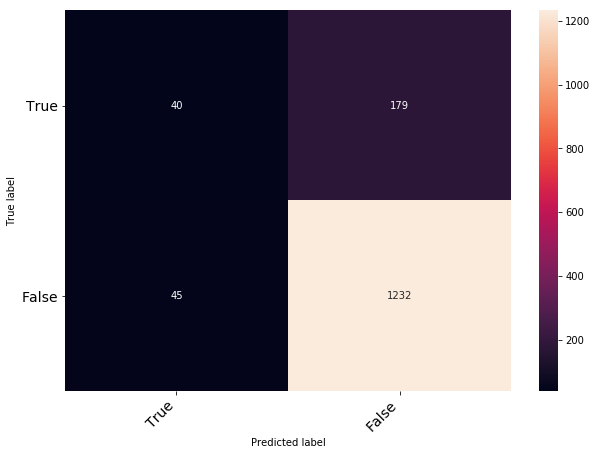

In [31]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
tfidf_model = TfidfVectorizer()
tfidf_vect_train = tfidf_model.fit_transform(X_train)
tfidf_vect_test = tfidf_model.fit(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names

list_of_sentance_train=[]
list_of_sentance_test=[]

for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
    
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model3 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'f1', cv=5)
model3.fit(tfidf_sent_vectors_train, y_train)
print(model3.best_estimator_)
y_pred = model3.predict(tfidf_sent_vectors_test);
print(model3.score(tfidf_sent_vectors_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using TFIDF weighted W2V and L1 regularizer= ",roc_auc)

# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 1496/1496 [00:04<00:00, 307.04it/s]


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9147748418310383
The AUC Score of test data using TFIDF weighted W2V and L2 regularizer=  0.5679639423162879


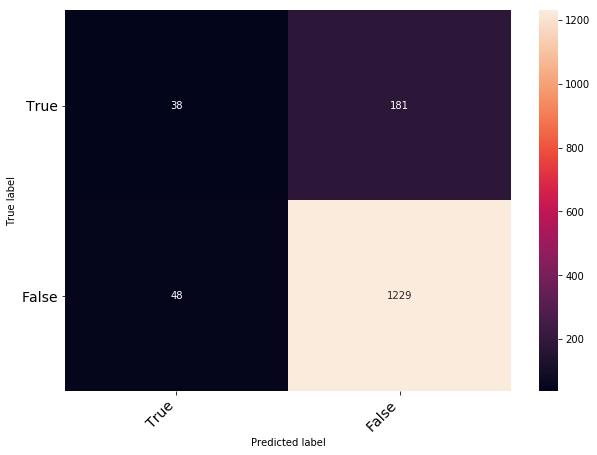

In [32]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
list_of_sentance_test=[]

for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
    
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

# Apply LR with L1 regularizer and GridSearchCV
from sklearn.linear_model import LogisticRegression
model3 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'f1', cv=5)
model3.fit(tfidf_sent_vectors_train, y_train)
print(model3.best_estimator_)
y_pred = model3.predict(tfidf_sent_vectors_test);
print(model3.score(tfidf_sent_vectors_test, y_test))

# Code to print the AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data using TFIDF weighted W2V and L2 regularizer= ",roc_auc)


# Code to print confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

# [6] Conclusions

In [51]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Regularizer", "Hyperparamater: C value", "AUC"]
x.add_row(["BoW","L1", 1, 0.72])
x.add_row(["BoW","L2", 1, 0.72])
x.add_row(["TFIDF","L1", 1, 0.65])
x.add_row(["TFIDF","L2", 100, 0.78])
x.add_row(["AVG-W2V","L1", 100, 0.59])
x.add_row(["AVG-W2V","L2", 100, 0.53])
x.add_row(["TFIDF-Weighted-W2V","L1", 100, 0.53])
x.add_row(["TFIDF-Weighted-W2V","L2", 10000, 0.54])
print(x)


+--------------------+-------------+-------------------------+------+
|     Vectorizer     | Regularizer | Hyperparamater: C value | AUC  |
+--------------------+-------------+-------------------------+------+
|        BoW         |      L1     |            1            | 0.72 |
|        BoW         |      L2     |            1            | 0.72 |
|       TFIDF        |      L1     |            1            | 0.65 |
|       TFIDF        |      L2     |           100           | 0.78 |
|      AVG-W2V       |      L1     |           100           | 0.59 |
|      AVG-W2V       |      L2     |           100           | 0.53 |
| TFIDF-Weighted-W2V |      L1     |           100           | 0.53 |
| TFIDF-Weighted-W2V |      L2     |          10000          | 0.54 |
+--------------------+-------------+-------------------------+------+
